# Sampling Landscape Photos by using Generative Models

-------------

## Motivation

Da ich leidenschaftlich gerne fotografiere und sich meine Fotografie hauptsächlich auf die Landschaftsfotografie fokussiert, bin ich sehr interessiert ein generatives Modell zu erstellen, das selber Landschaften kreieren kann.

Impressionen: https://500px.com/p/visualframing?view=photos

In [1]:
!nvidia-smi

Thu Mar 10 10:08:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   24C    P0    27W / 250W |      0MiB / 16280MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import PIL
import os
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

from prg.networks import Generator, Discriminator

/users/sstaehli/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# Data

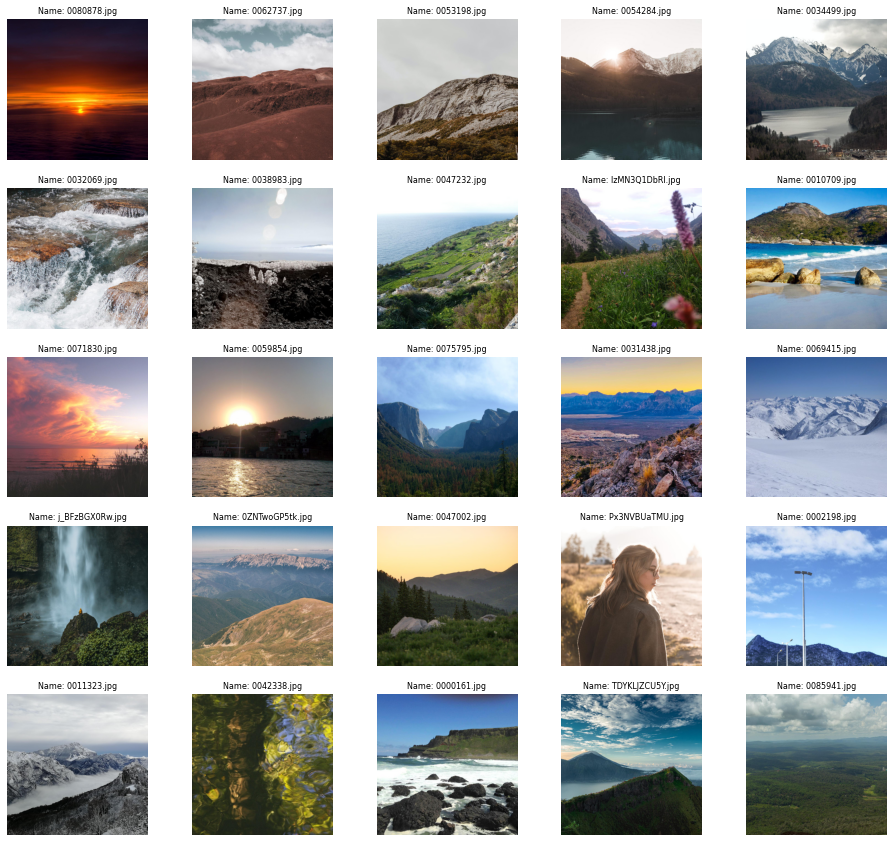

In [3]:
N_IMAGES = 25
SEED = 11

np.random.seed(SEED)
random_images = np.random.choice(os.listdir('./data/images'), size=N_IMAGES, replace=False)
ncols = 5
nrows = N_IMAGES // ncols
fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows))

for i, img in enumerate(random_images):
    plt.subplot(nrows, ncols, i+1)
    image = PIL.Image.open('./data/images/' + img)
    plt.imshow(image)
    plt.title('Name: '+img, fontsize=8)
    plt.axis('off')
    
plt.show()

**Beschreibung:**

Der zugrundeliegende Datensatz besteht aus Bildern die aus zwei Datensätzen zusammengesetzt wurden. Ein Teil der Bilder wurde aus einem Datensatz bestehend aus Landschaftsbildern erstellt und der andere wurde von der Plattform Unsplash gescrapt. Die Bilder vom Landschaftsdatensatz haben eine eindeutige NUmmerierung, wobei die selbstgescrapten Bilder über einen vermischten Namen mit Buchstaben und Zahlen besteht. Eine Annahme könnte sein, dass die gescrapten Bilder leider auch Bilder beinhalten die zwar als Landschaftsbild auf der Plattform angepriesen werden, doch eigentlich keine Landschaftsbilder sind. (siehe ganz oben mittleres Bild).
Die Beispielbilder zeigen, dass die Bilder meistes aus Landschaftsbilder bestehen. Es gibt jedoch auch Bilder die bspw. Tiere oder auch Menschen enthalten. Dies könnte durchaus ein Problem werden bei der Erzeugung der Bilder. Die Hoffnung besteht jedoch darin, dass dies den Output nicht stark beeinflussen wird, da der Anteil solcher Bilder sehr klein ist.
Falls das Problem die Outputs drastisch verschlechtern würde, dann würde ich die hinzugefügten Bildern entfernen und ohne diese trainieren.

In [4]:
# Params 
BATCH_SIZE = 32
WORKERS = 12
IMAGE_ROOT = './data/images'

In [5]:
from prg.data import get_dataloader

In [6]:
dataloader = get_dataloader(root_dir=IMAGE_ROOT, 
                            transforms=transforms.Compose([transforms.ToTensor(),
                                                           transforms.Normalize((0.5, 0.5, 0.5),
                                                                                (0.5, 0.5, 0.5))]),
                            batch_size=BATCH_SIZE, workers=WORKERS)

In [7]:
real_batch = next(iter(dataloader))

In [8]:
assert len(real_batch) == BATCH_SIZE
print('--- Test Passed ---')
del real_batch

--- Test Passed ---


In [9]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


# DCGAN - Deep Convolutional Generative Adversial Network

[<img src="./doc/dcgan_generator.png" width="500"/>](image.png)

- Im Generator müssen eventuell die Strides erhöht werden falls Checkerboard-Effekt auftritt bei den Output Bildern.

In [10]:
from prg.networks import Generator, Discriminator

In [11]:
z_vec = torch.rand(64,100,1,1)
print('Z-Vector:', z_vec.shape)

Z-Vector: torch.Size([64, 100, 1, 1])


In [12]:
# Test Generator
generator = Generator(z_dim=z_vec.shape[1])
out = generator(z_vec)
assert out.shape == torch.Size([64, 3, 1024, 1024])
print('--- Test Passed ---')

--- Test Passed ---


In [13]:
# Test Discrimnator
sample_image = torch.rand((3, 1024, 1024))
sample_image = sample_image.unsqueeze(0)
discriminator = Discriminator()
out = discriminator(sample_image)
assert out.shape == torch.Size([1, 1, 1, 1])
print('--- Test Passed ---')

--- Test Passed ---


## Model Training

In [14]:
def train_network(generator, discriminator, criterion, 
                  optimizer_generator, optimizer_discriminator, 
                  n_epochs, dataloader, epsilon=.001, debug_run=False):
    """
    Trains GAN by using batch-wise fake and real data inputs.
    
    params:
    --------------------
    generator: torch.Network
        Generator model to sample image from latent space.
        
    discriminator: torch.Network
        Discrimantor Model to classify into real or fake.
        
    criterion: 
        Cost-Function used for the network optimizatio
        
    optimizer: torch.Optimizer
        Optmizer for the network
        
    n_epochs: int
        Defines how many times the whole dateset should be fed through the network
        
    dataloader: torch.Dataloader 
        Dataloader with the batched dataset of real data.
        
    epsilon: float
        Stopping Criterion regarding to change in cost-function between two epochs.
        
    debug_run:
        If true than only one batch will be put through network.
        
    returns:
    ---------------------
    generator:
        Trained Torch Generator Model
        
    discriminator:
        Trained Torch Discriminator Model
        
    losses: dict
        dictionary of losses of all batches and Epochs.
        
    """
    print(20*'=', 'Start Training', 20*'=')
    training_loss_generator, training_loss_discriminator = [], []
    batch_losses, epoch_losses = [], []
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    generator.to(dev), discriminator.to(dev)
    criterion.to(dev)

    generator.train(), discriminator.train()
    overall_length = len(dataloader)

    with tqdm(total=n_epochs*overall_length, disable=debug_run) as pbar:
        for epoch in range(n_epochs):  # loop over the dataset multiple times
            discriminator_running_loss, generator_running_loss = 0.0, 0.0
            for i, data in enumerate(dataloader):                
                ###### REAL IMAGES - Training Discriminator ######
                # Get Batch of real images and pass to Discriminator which first trains on only real data.
                real_images = data
                real_images = real_images.to(dev)
                
                discriminator.zero_grad()
                # Create real labels
                labels = torch.full(size=(real_images.shape[0], ), fill_value=real_label, 
                                    dtype=torch.float, device=device)
                
                # Pass into Discriminator
                out = discriminator(real_images).reshape(-1)
                loss_real = criterion(out, labels)
                loss_real.backward()
                
                ## Generate Batch of latent vectors
                z_vec = torch.randn(real_images.shape[0], Z_DIM, 1, 1, device=device)
                # Passs to generator
                fake_images = generator(z_vec)
                labels = torch.full(size=(real_images.shape[0], ), fill_value=fake_label, 
                                    dtype=torch.float, device=device)
                
                # Passed generated images to discriminator
                out = discriminator(fake_images.detach()).reshape(-1)
                loss_fake = criterion(out, labels)
                loss_fake.backward()
                
                # Calculate overall loss over both
                discriminator_running_loss += loss_fake.mean().item() + loss_real.mean().item()
                
                # Udpate Discriminator
                optimizer_discriminator.step()
                
                ###### FAKE - Training of Generator ######
                generator.zero_grad()
                labels = torch.full(size=(real_images.shape[0], ), fill_value=real_label, 
                                    dtype=torch.float, device=device)
                out = discriminator(fake_images).reshape(-1)
                loss_generator = criterion(out, labels)
                loss_generator.backward()
                
                generator_running_loss += out.mean().item()
                
                # Update G
                optimizer_generator.step()

                # calc and print stats
                pbar.set_description(f'Epoch: {epoch+1}/{n_epochs} // GRL: {np.round(generator_running_loss, 3)}  -- '+
                                     f'DRL: {np.round(discriminator_running_loss, 3)}')
                pbar.update(1)
                if debug_run:
                    print('- Training Iteration passed. -')
                    break

            print(f'Epoch {epoch+1} // GRL: {np.round(generator_running_loss, 3)}  -- '+
                  f'DRL: {np.round(discriminator_running_loss, 3)}')
            
                  
            training_loss_generator.append(generator_running_loss)
            training_loss_discriminator.append(discriminator_running_loss)
            if epoch > 0:
                diff = np.abs(training_loss_generator[-2] - generator_running_loss)
                if diff < epsilon:
                    print('- Network Converged. Stopping Training. -')
                    break
                    
            if debug_run:
                # Breaks loop 
                break
        
    print(20*'=', 'Finished Training', 20*'=')
                                                 
    return generator, discriminator, dict(generator=generator_running_loss,
                                          discriminator=discriminator_running_loss)


In [15]:
discriminator = Discriminator()
generator = Generator()

In [16]:
torch.cuda.empty_cache()
##### Training Parameters #####
Z_DIM = 100
N_EPOCHS = 5
DEBUG_RUN = False

dataloader = get_dataloader(root_dir=IMAGE_ROOT, 
                            transforms=transforms.Compose([transforms.ToTensor(),
                                                           transforms.Normalize((0.5, 0.5, 0.5),
                                                                                (0.5, 0.5, 0.5))]),
                            batch_size=BATCH_SIZE, workers=WORKERS)
# Defines label to train on 
real_label = 1 # is_real == 1
fake_label = 0 # is_not_real == 0

criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=.001)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=.001)

generator, discriminator, loss = train_network(generator=generator, discriminator=discriminator, 
                                               criterion=criterion, optimizer_generator=optimizer_generator, 
                                               optimizer_discriminator=optimizer_discriminator, n_epochs=N_EPOCHS, 
                                               dataloader=dataloader, debug_run=DEBUG_RUN)

==================== Start Training ====================


  0%|          | 0/18690 [00:00<?, ?it/s]

NameError: name 'running_loss' is not defined

# Sources

https://paperswithcode.com/dataset/lhq

https://universome.github.io/alis

https://arxiv.org/pdf/1511.06434.pdf

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html